In [146]:
import csv
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [147]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [148]:
NUM_CLASSES = 10

In [149]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [150]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [151]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [152]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [153]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [154]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [155]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [156]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 0s - loss: 2.0070 - accuracy: 0.1172
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
2/2 [==============================] - 1s 179ms/step - loss: 2.0122 - accuracy: 0.1117 - val_loss: 1.9388 - val_accuracy: 0.1667
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 2.0499 - accuracy: 0.0938
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 2.0106 - accuracy: 0.1117 - val_loss: 1.9108 - val_accuracy: 0.1667
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.9542 - accuracy: 0.1094
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
2/2 [==============================] - 0s 42ms/step - loss: 1.9530 - accuracy: 0.1066 - val_loss: 1.8863 - val_accuracy: 0.1667
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.9033 - accuracy: 0.0547
Epoch 4: sa

In [157]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 [==============================] - 0s 22ms/step - loss: 0.0821 - accuracy: 1.0000


In [158]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [159]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 57ms/step
[7.3584792e-21 9.9999523e-01 2.4135999e-12 4.7243059e-10 4.7805152e-06
 7.3232150e-12]
1


3/3 [==============================] - 0s 1ms/step


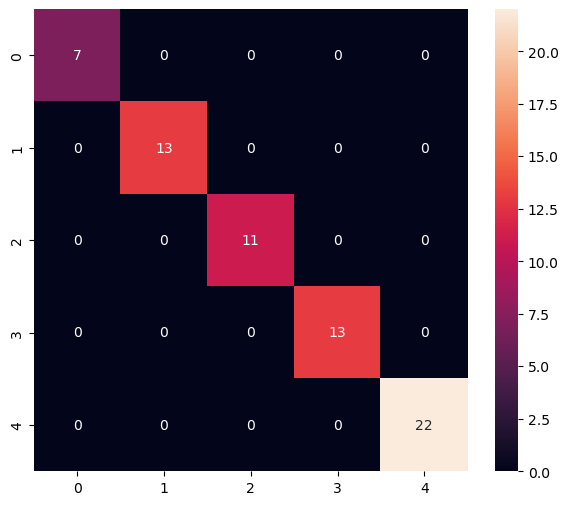

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        22

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [161]:

# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [162]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpgpkhedj5/assets


INFO:tensorflow:Assets written to: /tmp/tmpgpkhedj5/assets
2022-11-11 09:24:23.224263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-11 09:24:23.224289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-11 09:24:23.224426: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgpkhedj5
2022-11-11 09:24:23.225807: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-11 09:24:23.225833: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgpkhedj5
2022-11-11 09:24:23.231769: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-11 09:24:23.275954: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgpkhedj5
2022-11-11 09:24:23.288383: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6696